In [10]:
! pip install   scipy

In [4]:

%load_ext autoreload
%autoreload 2
# from covid_constants_and_util import *
# import helper_methods_for_aggregate_data_analysis as helper
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import json
import datetime
# import scipy
import time

JUST_TESTING = False


In [8]:
plt.show()

# Find out all placekeys

In [9]:
! pip install natsort

In [10]:
from natsort import natsorted
import glob
import sys
import numpy as np

def get_all_files(root_dir, extions=[".gz"]):
    found_files = []
    for rt_dir, dirs, files in os.walk(root_dir):
        for ext in extions:
            ext = ext.lower()
            ext_len = len(ext)
            for file in files:
                file_ext = file[-(ext_len):]
                # print(file)
                file_ext = file_ext.lower()
                if file_ext == ext:
                    file_name = os.path.join(rt_dir, file)
                    found_files.append(file_name)

    return found_files


def get_dir_from_files(files):
    dirs = [os.path.dirname(f) for f in files]
    dirs = list(set(dirs))
    return dirs


In [64]:
root_dir = r'H:\Safegraph\Weekly Places Patterns (for data from 2020-11-30 to Present)\patterns'  
saved_path = r'H:\Safegraph_reorganized\Placekeys_all_weekly_patterns_2021_release'

found_files = get_all_files(root_dir, extions=[".gz"])
dirs = get_dir_from_files(found_files)
dirs = natsorted(dirs, reverse=True)[:]

def extract_placekeys_visits():
    root_dir = r'H:\Safegraph\Weekly Places Patterns (for data from 2020-11-30 to Present)\patterns'  
    saved_path = r'H:\Safegraph_reorganized\Placekeys_all_weekly_patterns_2021_release'
    found_files = get_all_files(root_dir, extions=[".gz"])
    dirs = get_dir_from_files(found_files)
    dirs = natsorted(dirs, reverse=True)[:]

    usecol_old = ['placekey', 'parent_placekey', 'safegraph_place_id', 'parent_safegraph_place_id']
    usecol_new = ['placekey', 'parent_placekey']
    
    drop_colums = ['street_address', 'city', 'postal_code', 'date_range_start', 
                   'date_range_end', 'visits_by_day', 'visits_by_each_hour',
                  'visitor_home_cbgs', 'visitor_daytime_cbgs', 'visitor_country_of_origin', 'distance_from_home', 'median_dwell']
    
    concated_df = None
    is_first_df = True
    
    total = len(dirs)
    while len(dirs) > 0:
        try:
            d = dirs.pop(0)
            print("Processing directory: ", d)
            # print(idx, csv)
            csv_files = glob.glob(os.path.join(d, "*csv.gz"))
            csv_files = natsorted(csv_files)

            # print(csvs)
            dfs = []
            pid_str = str(os.getpid())
            print(f"    PID {pid_str: >6} reading CSV files...")
            for idx, csv in enumerate(csv_files[:]):

                print(f"    PID {pid_str: >6} reading:", os.path.basename(csv))
                
                csv_columns = pd.read_csv(csv, nrows=0).columns.to_list()
                
                if 'safegraph_place_id' in csv_columns:
                    usecols = usecol_old
                else:
                    usecols = usecol_new                   
                        
                usecols.append('raw_visitor_counts')
                
                df = pd.read_csv(csv, usecols=usecols, nrows=100, dtype={'raw_visitor_counts':int})
                df['raw_visitor_counts'] = df['raw_visitor_counts'].astype(int)
                
                # get the start date
                dir_name = os.path.dirname(d)                
                start_date = dir_name[-10:].replace('\\', r'-').replace(r'/', r'-')
                
                df = df.rename(columns={'raw_visitor_counts':f"visitor_{start_date}"})
#                 print(f"    Start_date: {start_date}", df.columns)
                
                if is_first_df:
                    concated_df = df
                    is_first_df = False
                    continue

                old_row_cnt = len(concated_df)
                concated_df = pd.concat([concated_df, df]).drop_duplicates(subset='placekey').reset_index(drop=True)
                new_row_cnt = len(concated_df)
                print(f'    PID {os.getpid()}: Current rows counts: {new_row_cnt}, previous rows: {old_row_cnt}. Added {new_row_cnt - old_row_cnt}, removed {old_row_cnt + len(df) - new_row_cnt} duplated rows.')
                

            print(f"Processed {total - len(dirs)} / {total}.")
    
        except Exception as e:
            print("Error in process_dir() while loop:", e, d, csv)
            exception_type, exception_object, exception_traceback = sys.exc_info()
            filename = exception_traceback.tb_frame.f_code.co_filename
            line_number = exception_traceback.tb_lineno
            print("Linenumber: ", line_number, filename)
            
    # compute the all visitors
    vistors_np = concated_df.drop(columns=usecols[:4])
    vistors_np = np.nan_to_num(vistors_np, nan=0)
    
#     concated_df['total_visitors'] = vistors_np.sum(axis=0)
    print(concated_df.drop(columns=usecols[:4]))
    new_name = os.path.join(saved_path, "all_placekey.csv")
    if not os.path.exists(saved_path):
        os.makedirs(saved_path)
    concated_df.to_csv(new_name, index=False)
    print("Done.")
    return concated_df

extract_placekeys_visits(dirs[:2], saved_path)

Processing directory:  H:\Safegraph\Weekly Places Patterns (for data from 2020-11-30 to Present)\patterns\2021\07\14\17
    PID  24732 reading CSV files...
    PID  24732 reading: patterns-part1.csv.gz
    PID  24732 reading: patterns-part2.csv.gz
    PID 24732: Current rows counts: 200, previous rows: 100. Added 100, removed 0 duplated rows.
    PID  24732 reading: patterns-part3.csv.gz
    PID 24732: Current rows counts: 300, previous rows: 200. Added 100, removed 0 duplated rows.
    PID  24732 reading: patterns-part4.csv.gz
    PID 24732: Current rows counts: 400, previous rows: 300. Added 100, removed 0 duplated rows.
    PID  24732 reading: patterns-part5.csv.gz
    PID 24732: Current rows counts: 500, previous rows: 400. Added 100, removed 0 duplated rows.
    PID  24732 reading: patterns-part6.csv.gz
    PID 24732: Current rows counts: 600, previous rows: 500. Added 100, removed 0 duplated rows.
    PID  24732 reading: patterns-part7.csv.gz
    PID 24732: Current rows counts: 7

KeyError: "['raw_visitor_counts' 'raw_visitor_counts'] not found in axis"

In [7]:
MSA_cbg_csv = r'H:\covid_mobility_results\new_census_data\ACS_2019_5YR_BG\ACS_race_cbsa_income_2019.zip'

msa_df = pd.read_csv(MSA_cbg_csv)
msa_df

FileNotFoundError: [Errno 2] No such file or directory: 'H:\\covid_mobility_results\\new_census_data\\ACS_2019_5YR_BG\\ACS_race_cbsa_income_2019.zip'

In [22]:
COLS_FROM_CORE_PLACES = ['safegraph_place_id', 'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids', 
                         'brands', 'top_category', 'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
                         'city', 'region', 'postal_code', 'open_hours']
COLS_FROM_CORE_PLACES_FOOTPRINT = ['safegraph_place_id', 'polygon_class', 'area_square_feet']
COLS_FROM_WEEKLY_PATTERNS = ['safegraph_place_id', 'poi_cbg', 'visitor_home_cbgs', 'visitor_daytime_cbgs', 
                             'visitor_country_of_origin', 'distance_from_home', 'median_dwell', 'bucketed_dwell_times']

# core_dir = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/04/08/06/'
core_dir = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00'   # No column of safegraph_place_id since July

# core_dir = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/07/07/21/'
# core_dir = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/09/03/22/'  # No column of safegraph_place_id since July


for filename in sorted(os.listdir(core_dir))[:2]:
    print(filename)

    if filename.startswith('core_poi-part'):

        path_to_csv = os.path.join(core_dir, filename)


        print('Loading', path_to_csv)
        
#         df = pd.read_csv(path_to_csv)

        path_to_csv = [path_to_csv]  # Huan
        
#         df = load_csv_possibly_with_dask(path_to_csv, usecols=cols_to_keep, use_dask=True)
        df = load_csv_possibly_with_dask(path_to_csv, usecols=COLS_FROM_CORE_PLACES, use_dask=False)  # Huan
        dfs.append(df)


_SUCCESS
core_poi-part1.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part1.csv.gz


100%|██████████| 1/1 [00:12<00:00, 12.46s/it]


NameError: name 'dfs' is not defined

In [4]:
import os

path_0 = r'/media/gpu/easystore/Safegraph'
os.path.basename(path_0)

'Safegraph'

In [ ]:
shp_dir = r'E:\USC_OneDrive\OneDrive - University of South Carolina\Research\Mobility_covid\CORE_pois'

# Process for each week

## merge CORE POI, Geometry Footprint

In [3]:
import pandas as pd

core_poi_df_202106 = pd.read_csv(r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/POI_merged_not_parents_202106.csv')

print(f"Row count of core_poi_df_202106: {len(core_poi_df_202106)}")
core_poi_df_202106.sample(2)
                                          

/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (3,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Row count of core_poi_df_202106: 6003800


,placekey,safegraph_place_id,parent_placekey,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,...,postal_code,iso_country_code,phone_number,open_hours,category_tags,opened_on,closed_on,tracking_opened_since,tracking_closed_since,month
149281,225-222@5pn-kbb-9cq,sg:c45657de7a3b4781acc486cd4576ee1f,NaN,NaN,Saturn Drive Baptist Church,NaN,NaN,Religious Organizations,Religious Organizations,813110.0,...,37217,US,1.615361e+10,NaN,NaN,NaN,NaN,NaN,2019-07,2021-06
4461573,222-222@63s-cfp-wc5,sg:aa774df04b6f471496915d96ae7a0bb5,NaN,NaN,Railroad Street Bar and Grill,NaN,NaN,Restaurants and Other Eating Places,Full-Service Restaurants,722511.0,...,19468,US,1.610496e+10,"{ ""Mon"": [], ""Tue"": [[""11:00"", ""24:00""]], ""Wed...","Bar or Pub,Pizza,Late Night",NaN,NaN,NaN,2019-07,2021-06


In [9]:
import os

core_poi_df_202107_dir = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/07'
core_poi_df_202107 = pd.concat(map(pd.read_csv, get_all_files(root_dir=core_poi_df_202107_dir, extions=[".gz"])))
core_poi_df_202107 = core_poi_df_202107.drop_duplicates(subset='placekey').reset_index(drop=True)

print(f"Row count of core_poi_df_202107: {len(core_poi_df_202107)}")
core_poi_df_202107.sample(2)

Row count of core_poi_df_202107: 6484514


,placekey,parent_placekey,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,region,postal_code,iso_country_code,phone_number,open_hours,category_tags,opened_on,closed_on,tracking_closed_since,geometry_type
4878585,zzy-229@5pw-5zw-k9f,224-22m@5pw-5zw-k9f,Boonie Foods,NaN,NaN,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,41.879761,-87.630570,...,IL,60603,US,NaN,NaN,NaN,NaN,NaN,2019-07,POLYGON
5723170,223-222@5qv-vf8-ty9,zzw-222@5qv-vf8-ty9,Raising Cane's,SG_BRAND_8017619598f197e2494560ec1e052c69,Raising Cane's,Restaurants and Other Eating Places,Full-Service Restaurants,722511.0,32.908227,-96.559753,...,TX,75088,US,1.972413e+10,"{ ""Mon"": [[""10:00"", ""23:00""]], ""Tue"": [[""10:00...","Counter Service,Late Night,Lunch,Fast Food,Dri...",NaN,NaN,2019-07,POLYGON


In [18]:
def remove_parent_poi(df):
    old_row_cnt = len(df)
    print(f"Raw row count: {old_row_cnt}")
    parent_placekeys = df['parent_placekey'].unique()
    print(parent_placekeys)
    parent_placekeys = list(parent_placekeys)
    print(f"Find parent placekeys count: {len(parent_placekeys)}")
    df = df[~df['placekey'].isin(parent_placekeys)]
    new_row_cnt = len(df)
    remove_row_cnt = old_row_cnt - new_row_cnt
    print(f"Remove row count: {remove_row_cnt}")
    print(f"New row count: {new_row_cnt}")
    return df

core_poi_df_202107 = remove_parent_poi(core_poi_df_202107)

Raw row count: 6484514
['222-223@3x5-4sw-d35' nan 'zzw-222@8g6-x75-q2k' ... '227-223@5qs-zjq-b8v'
 '222-222@8fb-b7z-4d9' '226-222@5q6-sgb-z4v']
Find parent placekeys count: 216259
Remove row count: 216258
New row count: 6268256


,placekey,parent_placekey,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,region,postal_code,iso_country_code,phone_number,open_hours,category_tags,opened_on,closed_on,tracking_closed_since,geometry_type
0,222-222@3x5-4sw-d35,222-223@3x5-4sw-d35,Divine's Convenience & Auto Repair Shops,SG_BRAND_69d4a2b66d1aea33,Divine's Convenience & Auto Repair Shops,"Automotive Parts, Accessories, and Tire Stores",Automotive Parts and Accessories Stores,441310.0,47.671198,-117.239190,...,WA,99206,US,NaN,NaN,NaN,NaN,NaN,2019-07,POLYGON
1,224-222@63r-6hr-5pv,NaN,Fallsgrove Center for Dentistry,NaN,NaN,Offices of Dentists,Offices of Dentists,621210.0,39.098552,-77.192122,...,MD,20850,US,NaN,"{ ""Mon"": [[""8:00"", ""17:00""]], ""Tue"": [[""8:00"",...",NaN,NaN,NaN,2019-07,POLYGON
2,zzw-222@63r-6y3-45f,NaN,CubeSmart,SG_BRAND_3609f80e8ab3db987d9be5010a726c20,CubeSmart,Lessors of Real Estate,Lessors of Miniwarehouses and Self-Storage Units,531130.0,39.105704,-77.184065,...,MD,20850,US,NaN,NaN,NaN,2020-06,NaN,2019-07,POLYGON
3,224-222@5zb-xcw-t7q,NaN,T Mobile Store,SG_BRAND_4b82356db1a8f4a2db26dd5b7e30abba,T-Mobile,Wired and Wireless Telecommunications Carriers,Wireless Telecommunications Carriers (except S...,517312.0,33.466524,-112.152419,...,AZ,85035,US,1.623738e+10,"{ ""Mon"": [[""10:00"", ""21:00""]], ""Tue"": [[""10:00...",NaN,NaN,NaN,2019-07,POLYGON
4,227-222@629-fv8-xqz,NaN,United States Postal Service (USPS),SG_BRAND_27ee73cd1fb6f5e432852fea401eacce,United States Postal Service (USPS),Postal Service,Postal Service,491110.0,41.629980,-74.372417,...,NY,12588,US,1.845744e+10,NaN,NaN,NaN,NaN,2020-12,POLYGON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6484509,222-222@5s6-c3y-ht9,NaN,Subway,SG_BRAND_de80593878cb1673c62a7f338dc7e4e1,Subway,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,41.451936,-85.585851,...,IN,46767,US,1.260895e+10,"{ ""Mon"": [[""8:00"", ""22:00""]], ""Tue"": [[""8:00"",...","Counter Service,Sandwich Shop,Lunch,Breakfast,...",NaN,NaN,2019-07,POLYGON
6484510,zzw-223@63f-9rq-6x5,zzw-222@63f-9rq-6zf,Food Lion,SG_BRAND_7e98d750c0dde403bb1d17623945992d,Food Lion,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,36.582622,-79.337527,...,VA,24540,US,NaN,NaN,NaN,NaN,NaN,2019-07,POLYGON
6484511,229-222@63j-8r7-pjv,NaN,Queen City Office Technologies,NaN,NaN,"Office Supplies, Stationery, and Gift Stores",Office Supplies and Stationery Stores,453210.0,39.099966,-84.598968,...,OH,45238,US,1.513252e+10,"{ ""Mon"": [[""8:00"", ""16:30""]], ""Tue"": [[""8:00"",...",NaN,NaN,2020-01,2019-07,POLYGON
6484512,22b-223@62j-ppq-f2k,NaN,Advanced Auto Collision Center,NaN,NaN,Automotive Repair and Maintenance,"Automotive Body, Paint, and Interior Repair an...",811121.0,42.751155,-71.128221,...,MA,1844,US,1.978682e+10,NaN,NaN,NaN,NaN,2019-07,POLYGON


In [20]:
old_row_cnt = len(core_poi_df_202106)
concated_df = pd.concat([core_poi_df_202107, core_poi_df_202106]).drop_duplicates(subset='placekey').reset_index(drop=True)
new_row_cnt = len(concated_df)
print(f'    PID {os.getpid()}: Current rows counts: {new_row_cnt}, previous rows: {old_row_cnt}. Added {new_row_cnt - old_row_cnt}, removed {old_row_cnt + len(core_poi_df_202106) - new_row_cnt} duplated rows.')


/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


NameError: name 'df' is not defined

In [22]:
new_row_cnt = len(concated_df)
print(f'    PID {os.getpid()}: Current rows counts: {new_row_cnt}, previous rows: {old_row_cnt}. Added {new_row_cnt - old_row_cnt}, removed {old_row_cnt + len(core_poi_df_202106) - new_row_cnt} duplated rows.')


    PID 14452: Current rows counts: 7096235, previous rows: 6003800. Added 1092435, removed 4911365 duplated rows.


In [23]:
concated_df.to_csv(r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/POI_merged_not_parents_202107.csv', index=False)

## Merge non_parents_POI to square ft, and add safegraph_place_ID

In [58]:
core_POI_202107_non_parent = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/POI_merged_not_parents_202107.csv'
POI_202107_df = pd.read_csv(core_POI_202107_non_parent)
print(f"Row count of POI_202107_df: {len(POI_202107_df)}")
POI_202107_df.sample(2)

/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (3,4,9,12,13,14,20,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Row count of POI_202107_df: 7096235


,brands,category_tags,city,closed_on,geometry_type,iso_country_code,latitude,location_name,longitude,month,...,placekey,postal_code,region,safegraph_brand_ids,safegraph_place_id,street_address,sub_category,top_category,tracking_closed_since,tracking_opened_since
7059618,NaN,NaN,Marshfield,NaN,NaN,US,44.677732,Marshfield Clinic Optical,-90.175165,2020-11,...,zzw-222@5s8-3zj-6tv,54449,WI,NaN,sg:c4d02b28c1bb49378ce9d31de41a1621,1000 N Oak Ave,Optical Goods Stores,Health and Personal Care Stores,2019-07,NaN
512549,NaN,NaN,Shoreline,NaN,POLYGON,US,47.774175,Go Natives Nursery,-122.384946,NaN,...,225-222@5x4-4dk-rrk,98177,WA,NaN,NaN,2112 NW 199th St,"Nursery, Garden Center, and Farm Supply Stores",Lawn and Garden Equipment and Supplies Stores,2019-07,NaN


In [42]:
POI_202107_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7096235 entries, 0 to 7096234
Data columns (total 26 columns):
brands                       object
category_tags                object
city                         object
closed_on                    object
geometry_type                object
iso_country_code             object
latitude                     float64
location_name                object
longitude                    float64
month                        object
naics_code                   float64
open_hours                   object
opened_on                    object
parent_placekey              object
parent_safegraph_place_id    object
phone_number                 float64
placekey                     object
postal_code                  int64
region                       object
safegraph_brand_ids          object
safegraph_place_id           object
street_address               object
sub_category                 object
top_category                 object
tracking_closed_sinc

In [59]:
geometry_area_csv = r'/media/gpu/easystore/Safegraph/Geometry Footprint/Geo_footprint_unqiue.csv'
geometry_area_df = pd.read_csv(geometry_area_csv)
print(f"Row count of geometry_area_csv: {len(geometry_area_df)}")
geometry_area_df.sample(2)

Row count of geometry_area_csv: 6374751


,safegraph_place_id,location_name,polygon_class,is_synthetic,includes_parking_lot,iso_country_code,area_square_feet
2840582,sg:9edaa0283e7d44939be39e9fe0bb9c50,Cal Trims,OWNED_POLYGON,True,NaN,US,4298
2898785,sg:1c8700e69fb64f3a820cb5922161c0bb,First Baptist Church South Tahoe Sbc,OWNED_POLYGON,False,False,US,4266


In [61]:
placekey_ID_mapping_csv = r'/media/gpu/easystore/Safegraph/Geometry/placekey_safegraph_id_mapping.csv0'
placekey_ID_mapping_df = pd.read_csv(placekey_ID_mapping_csv)
print(f"Row count of placekey_ID_mapping_df: {len(placekey_ID_mapping_df)}")
placekey_ID_mapping_df.sample(2)

Row count of placekey_ID_mapping_df: 5941711


,placekey,sg_g.safegraph_place_id
1367289,zzw-228@627-s8r-28v,sg:f22eeecabd454788b3cb1acd328bfaed
2299805,222-223@5s9-428-k2k,sg:3ee8ff4693424dd6839402bd967b755b


## Geometry 

In [12]:
! pip install geopandas 
import geopandas as gpd

You should consider upgrading via the '/media/gpu/easystore/covid-mobility-tool/env_v2/bin/python -m pip install --upgrade pip' command.


In [13]:
geometry_polygon_csv_dir = r'/media/gpu/easystore/Safegraph/Geometry/'

In [25]:
from shapely import wkt
%matplotlib notebook
%matplotlib widget


In [15]:
geometry_polygon_df = pd.concat(map(pd.read_csv, get_all_files(root_dir=geometry_polygon_csv_dir, extions=[".csv"])))
print(f"Row count of geometry_footprint_df: {len(geometry_polygon_df)}")

Row count of geometry_footprint_df: 6462532


In [16]:
geometry_polygon_df.sample(1)

,placekey,sg_g.safegraph_place_id,sg_g.parent_safegraph_place_id,sg_g.location_name,sg_g.brands,sg_g.latitude,sg_g.longitude,sg_g.street_address,sg_g.city,sg_g.region,sg_g.postal_code,sg_g.iso_country_code,sg_g.polygon_wkt,sg_g.polygon_class,sg_g.includes_parking_lot,sg_g.is_synthetic,sg_g.building_height,sg_g.enclosed
631491,22q-223@5z4-zwc-xbk,sg:a76139b9832c4bb4866fa43dc6ca1215,NaN,Gary R Cohan MD FACP,NaN,34.06826,-118.383538,150 N Robertson Blvd Ste 115,Beverly Hills,CA,90211,US,POLYGON ((-118.38357567682833 34.0683505768055...,SHARED_POLYGON,False,False,17.98,False


In [17]:
old_row_cnt = len(geometry_polygon_df)
geometry_polygon_df = geometry_polygon_df.dropna(subset=['sg_g.polygon_wkt'])
new_row_cnt = len(geometry_polygon_df)

print(f"Remove {old_row_cnt - new_row_cnt} rows.")

geometry_polygon_df['geometry'] = geometry_polygon_df['sg_g.polygon_wkt'].apply(wkt.loads)


Remove 520821 rows.


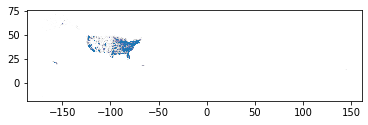

In [30]:
geometry_polygon_gdf = gpd.GeoDataFrame(geometry_polygon_df, geometry='geometry')
geometry_polygon_gdf.plot()

In [152]:
%matplotlib inline
geometry_polygon_gdf.sample(1)

,sg_g.safegraph_place_id,sg_g.parent_safegraph_place_id,sg_g.location_name,sg_g.brands,sg_g.latitude,sg_g.longitude,sg_g.street_address,sg_g.city,sg_g.region,sg_g.postal_code,sg_g.iso_country_code,sg_g.polygon_class,sg_g.includes_parking_lot,sg_g.is_synthetic,sg_g.building_height,sg_g.enclosed,geometry,area_meter
placekey,,,,,,,,,,,,,,,,,,
224-222@8fw-2rp-ghq,sg:bf0861375a5a47678e84aafafb3a8d03,NaN,Xtreme Fat Tire Bikes,NaN,26.313455,-80.080152,133 SE 18th Ave,Deerfield Beach,FL,33441,US,OWNED_POLYGON,False,False,NaN,False,"POLYGON ((10184997.150 1260861.220, 10184997.1...",3.520700e-08


In [112]:
geometry_polygon_gdf.crs = {'init': 'epsg:3857'}

In [113]:
geometry_polygon_gdf.set_crs("epsg:4326")

<class 'AttributeError'>: 'GeoDataFrame' object has no attribute 'set_crs'

In [114]:
geometry_polygon_gdf = geometry_polygon_gdf.to_crs(r'+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

# ESRI:102008
# North America Albers Equal Area Conic
# +proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs 

Exception ignored in: <function Collection.__del__ at 0x7f330dc4ebf8>
Traceback (most recent call last):
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/fiona/collection.py", line 471, in __del__
    self.close()
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/fiona/collection.py", line 444, in close
    if self.session is not None and self.session.isactive():
AttributeError: 'Collection' object has no attribute 'session'
Exception ignored in: <function Collection.__del__ at 0x7f330dc4ebf8>
Traceback (most recent call last):
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/fiona/collection.py", line 471, in __del__
    self.close()
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/fiona/collection.py", line 444, in close
    if self.session is not None and self.session.isactive():
AttributeError: 'Collection' object has no attribute 'session'


In [278]:
xy = geometry_polygon_gdf.sample(1)['geometry'][0].exterior.coords.xy
xy

(array('d', [10184968.770285267, 10184968.770373572, 10184968.7706466, 10184968.770558897, 10184968.770285267]),
 array('d', [1260828.1357910687, 1260828.1359357955, 1260828.135774717, 1260828.1356309538, 1260828.1357910687]))

In [258]:
list(zip(*xy))

[(10184988.828416228, 1260869.659946245),
 (10184988.828296335, 1260869.6597120087),
 (10184988.828269502, 1260869.659723689),
 (10184988.828288022, 1260869.6597571007),
 (10184988.828168396, 1260869.6598091926),
 (10184988.828277776, 1260869.6600065154),
 (10184988.828416228, 1260869.659946245)]

In [292]:
from shapely.geometry import Polygon

polygon = Polygon(list(zip(*xy)))
print(polygon)
polygon.area

POLYGON ((10184968.77028527 1260828.135791069, 10184968.77037357 1260828.135935795, 10184968.7706466 1260828.135774717, 10184968.7705589 1260828.135630954, 10184968.77028527 1260828.135791069))


5.3559432016412126e-08

In [293]:
polygon.bounds

(10184968.770285267, 1260828.1356309538, 10184968.7706466, 1260828.1359357955)

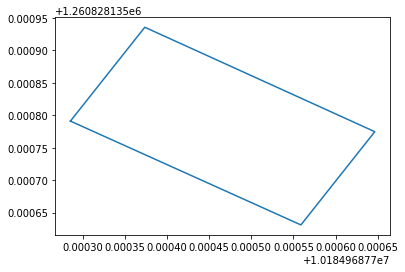

In [285]:
plt.plot(xy[0], xy[1])

In [221]:
p.length

0.010736473612424982

In [205]:
type(p.centroid)

shapely.geometry.point.Point

In [54]:
geometry_polygon_gdf['area_meter'] = geometry_polygon_gdf['geometry'].area
geometry_polygon_gdf = geometry_polygon_gdf.drop(columns='sg_g.polygon_wkt')
geometry_polygon_gdf.to_file(r'/media/gpu/easystore/Safegraph/Geometry/POI_polygons.shp')

In [ ]:
geometry_polygon_gdf = gpd.read_file(r'/media/gpu/easystore/Safegraph/Geometry/POI_polygons.shp')
geometry_polygon_gdf.sample(2)

[autoreload of IPython.utils.ipstruct failed: Traceback (most recent call last):
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/media/gpu/easystore/covid-mobilit

### Merge
CORE_POI + Sqaure feet + polygon area + safegraph_place_id

In [62]:
POI_202107_df = POI_202107_df.set_index('placekey')
POI_202107_df.sample(1)

,brands,category_tags,city,closed_on,geometry_type,iso_country_code,latitude,location_name,longitude,month,...,phone_number,postal_code,region,safegraph_brand_ids,safegraph_place_id,street_address,sub_category,top_category,tracking_closed_since,tracking_opened_since
placekey,,,,,,,,,,,,,,,,,,,,,
zzw-222@5xq-532-8sq,NaN,NaN,Santa Barbara,NaN,POLYGON,US,34.418403,Global Document Imaging,-119.678979,NaN,...,1.805585e+10,93103,CA,NaN,NaN,121 S Quarantina St Ste 265 Fl 1,NaN,Printing and Related Support Activities,2019-07,NaN


In [67]:
POI_202107_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7096235 entries, 222-222@3x5-4sw-d35 to nan
Data columns (total 25 columns):
brands                       object
category_tags                object
city                         object
closed_on                    object
geometry_type                object
iso_country_code             object
latitude                     float64
location_name                object
longitude                    float64
month                        object
naics_code                   float64
open_hours                   object
opened_on                    object
parent_placekey              object
parent_safegraph_place_id    object
phone_number                 float64
postal_code                  int64
region                       object
safegraph_brand_ids          object
safegraph_place_id           object
street_address               object
sub_category                 object
top_category                 object
tracking_closed_since        object
tracking_op

In [66]:
#geometry_area_df = geometry_area_df.set_index('placekey')
geometry_area_df.sample(1)

,safegraph_place_id,location_name,polygon_class,is_synthetic,includes_parking_lot,iso_country_code,area_square_feet
4357349,sg:7d96eb6cb16e4dc2a4d030bc1e4e7739,Strung Out On Beads,SHARED_POLYGON,False,False,CA,47069


In [74]:
# Merge  geometry_area_df and placekey_safegraph_place_id (add safegraph_place_id) to area_square_feet
old_row_cnt = len(geometry_area_df)
feet_area_placekey_df = geometry_area_df.merge(placekey_ID_mapping_df, left_on='safegraph_place_id', 
                                               right_on='sg_g.safegraph_place_id', how='inner')

print(f"feet_area_placekey_df row count:{len(feet_area_placekey_df)}")

feet_area_placekey_df.sample(2)

feet_area_placekey_df row count:5062019


,safegraph_place_id,location_name,polygon_class,is_synthetic,includes_parking_lot,iso_country_code,area_square_feet,placekey,sg_g.safegraph_place_id
4579778,sg:6a6c3facdbb641329e07096b722acbd1,Rossi Byron DDS,OWNED_POLYGON,False,False,US,3070,zzw-222@63d-v54-ct9,sg:6a6c3facdbb641329e07096b722acbd1
671582,sg:3220cc49492341a4995096bc334344b6,Kroger,SHARED_POLYGON,False,NaN,US,49516,zzw-223@8g6-t88-j35,sg:3220cc49492341a4995096bc334344b6


In [75]:
feet_area_placekey_df =  feet_area_placekey_df.rename({"sg_g.safegraph_place_id":"safegraph_place_id"})
feet_area_placekey_df

,safegraph_place_id,location_name,polygon_class,is_synthetic,includes_parking_lot,iso_country_code,area_square_feet,placekey,sg_g.safegraph_place_id
0,sg:001341fe7e794ab6bd65bb80759a1ac6,Old Firehouse School,OWNED_POLYGON,False,False,US,5495,zzw-227@5vg-7pj-9s5,sg:001341fe7e794ab6bd65bb80759a1ac6
1,sg:002921847f104c93a6df47bb831dedd2,Tenth Avenue Park,OWNED_POLYGON,False,NaN,US,388046,zzz-222@5sb-959-xh5,sg:002921847f104c93a6df47bb831dedd2
2,sg:002d2e9f047d47ca8661abb8939096cf,Hunter Village Wines & Liquors,SHARED_POLYGON,False,False,US,687,zzw-223@629-mc7-dqf,sg:002d2e9f047d47ca8661abb8939096cf
3,sg:0060616e5f184585a026a0b7e8192fbd,Fat Moe's,SHARED_POLYGON,False,False,US,10925,22m-222@627-vg9-8jv,sg:0060616e5f184585a026a0b7e8192fbd
4,sg:0061c1d8e124406cbcc97e40eb1dd585,Jungle Rapids Family Fun Park,OWNED_POLYGON,False,True,US,35487,222-222@645-9tv-r8v,sg:0061c1d8e124406cbcc97e40eb1dd585
...,...,...,...,...,...,...,...,...,...
5062014,sg:e505d72620ba4163bc30ead022149974,Total Wine & More,SHARED_POLYGON,False,False,US,2358,zzw-224@5x4-4nj-vvf,sg:e505d72620ba4163bc30ead022149974
5062015,sg:e6f74a71dbdf410c995e825165cc29f3,Western Union,OWNED_POLYGON,False,False,US,4100,222-222@63p-6y8-j5f,sg:e6f74a71dbdf410c995e825165cc29f3
5062016,sg:ed977afc64994ab4a09ade0854eb26d2,Western Union,SHARED_POLYGON,False,False,US,15057,222-222@5yv-hsr-xqz,sg:ed977afc64994ab4a09ade0854eb26d2
5062017,sg:fae0371cbbbd42fab5f9200e31e67b7d,Gaithersburg Pharmacy,OWNED_POLYGON,False,False,US,3246,226-222@63r-6xh-qvf,sg:fae0371cbbbd42fab5f9200e31e67b7d


In [88]:
feet_area_placekey_df =feet_area_placekey_df.drop(columns='sg_g.safegraph_place_id')
feet_area_placekey_df.sample(2)

,safegraph_place_id,location_name,polygon_class,is_synthetic,includes_parking_lot,iso_country_code,area_square_feet
placekey,,,,,,,
zzw-222@8g6-yd5-snq,sg:4cd3d9dbe10540ef99587712e36ebaf9,Asado Ministries,OWNED_POLYGON,False,False,US,6801
zzw-225@8gb-mhf-6tv,sg:216eb92138ad4718a4f5c420d66cb9ec,Northeast Georgia Physicians Group,SHARED_POLYGON,False,False,US,24496


In [ ]:
feet_area_placekey_df = feet_area_placekey_df.set_index('placekey')

In [148]:

feet_area_placekey_df.loc[['223-222@63r-6xh-qs5'], :]

,safegraph_place_id,location_name,polygon_class,is_synthetic,includes_parking_lot,iso_country_code,area_square_feet
placekey,,,,,,,
223-222@63r-6xh-qs5,sg:02f38ed54bb64212b13e1c3203538ff8,7-Eleven,OWNED_POLYGON,False,NaN,US,3531


In [151]:
#geometry_polygon_gdf = geometry_polygon_gdf.set_index('placekey')
geometry_polygon_gdf.sample(2)['geometry'].area


placekey
224-223@5nz-vvn-435    2.366741e-07
222-222@5px-ty4-zvf    2.427172e-06
dtype: float64

In [149]:
geometry_polygon_gdf.loc['225-222@63r-6xh-qs5', :]

sg_g.safegraph_place_id                         sg:bd166668a4b041a8ac485a8e81699291
sg_g.parent_safegraph_place_id                  sg:669c3471830143d49de4445fe5c5bdbe
sg_g.location_name                                               Tipicos El Encanto
sg_g.brands                                                                     NaN
sg_g.latitude                                                               39.1612
sg_g.longitude                                                              -77.163
sg_g.street_address                                   8035 Snouffer School Rd Ste I
sg_g.city                                                              Gaithersburg
sg_g.region                                                                      MD
sg_g.postal_code                                                              20879
sg_g.iso_country_code                                                            US
sg_g.polygon_class                                                    OWNED_

In [ ]:
geometry_polygon_gdf = geometry_polygon_gdf.set_index('placekey')

In [ ]:
merged_df = placekey_ID_mapping_df.merge(POI_202107_df, left_index=True, right_index=True)

In [ ]:
merged_df = merged_df.merge(geometry_polygon_gdf.drop(columns='geometry'), left_index=True, right_index=True)

### Split into state csv files

In [56]:
states_str = 

6

# Load a state data only

Need to merge a POI dataframe, including placekey, safegraph_place_id, POI category, area, poi_cgb, MAS, county, state...
- placekey: alway come with weekly data
- safegraph_place_id: removed after June 2020


## Load core_POI

No parent POIs.

In [15]:
core_poi_csv = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/POI_merged_not_parents_202107.csv'
core_poi_df = pd.read_csv(core_poi_csv)
print(f"Row count of core_poi_df: {len(core_poi_df)}")
core_poi_df.head(2)

/media/gpu/Seagate/covid-mobility-tool/env_v3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,4,9,12,13,14,20,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Row count of core_poi_df: 7096235


,brands,category_tags,city,closed_on,geometry_type,iso_country_code,latitude,location_name,longitude,month,...,placekey,postal_code,region,safegraph_brand_ids,safegraph_place_id,street_address,sub_category,top_category,tracking_closed_since,tracking_opened_since
0,Divine's Convenience & Auto Repair Shops,NaN,Spokane Valley,NaN,POLYGON,US,47.671198,Divine's Convenience & Auto Repair Shops,-117.239190,NaN,...,222-222@3x5-4sw-d35,99206,WA,SG_BRAND_69d4a2b66d1aea33,NaN,1520 N Pines Rd,Automotive Parts and Accessories Stores,"Automotive Parts, Accessories, and Tire Stores",2019-07,NaN
1,NaN,NaN,Rockville,NaN,POLYGON,US,39.098552,Fallsgrove Center for Dentistry,-77.192122,NaN,...,224-222@63r-6hr-5pv,20850,MD,NaN,NaN,14955 Shady Grove Rd Ste 200,Offices of Dentists,Offices of Dentists,2019-07,NaN


In [16]:
core_poi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7096235 entries, 0 to 7096234
Data columns (total 26 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   brands                     object 
 1   category_tags              object 
 2   city                       object 
 3   closed_on                  object 
 4   geometry_type              object 
 5   iso_country_code           object 
 6   latitude                   float64
 7   location_name              object 
 8   longitude                  float64
 9   month                      object 
 10  naics_code                 float64
 11  open_hours                 object 
 12  opened_on                  object 
 13  parent_placekey            object 
 14  parent_safegraph_place_id  object 
 15  phone_number               float64
 16  placekey                   object 
 17  postal_code                int64  
 18  region                     object 
 19  safegraph_brand_ids        object 
 20  sa

## Load area

In [26]:
core_poi_area_csv = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/core_POI_area.csv'
core_poi_area_df = pd.read_csv(core_poi_area_csv)
print(f"Row count of core_poi_df: {len(core_poi_area_df)}")
core_poi_area_df.head(2)

Row count of core_poi_df: 5941711


,location_name,polygon_class,is_synthetic,includes_parking_lot,iso_country_code,area_square_feet,sg_g.paren,sg_g.locat,sg_g.brand,sg_g.latit,...,sg_g.build,sg_g.enclo,area_meter,area_square_meter,placekey,convertd_area_meter,diff_area,diff_area_ratio,min_area,safegraph_place_id
0,Complete Computer Care,OWNED_POLYGON,False,False,US,2580.0,NaN,Complete Computer Care,NaN,40.270065,...,6.77,0.0,239.658301,239.658301,222-222@628-tbd-cwk,239.687848,0.029548,0.000123,239.658301,sg:000000c8f55d451ca1ae98bd057785a7
1,TechWorks,OWNED_POLYGON,False,False,US,1030.0,NaN,TechWorks,NaN,38.930941,...,10.24,0.0,95.644273,95.644273,228-222@63r-6bj-hnq,95.689335,0.045062,0.000471,95.644273,sg:000008c003ab41d9b6a8d1e58e4992ea


In [ ]:
core_poi_area_df

## Load MAS blockgroups

In [19]:
mas_csv = r'https://github.com/gladcolor/covid-mobility-tool/raw/main/ACS_2019_BG/ACS_race_cbsa_income_2019.zip'
mas_df = pd.read_csv(mas_csv)
print(f"Row count of mas_df: {len(mas_df)}")

Row count of mas_df: 219216


## Merge

In [ ]:
core_poi_df

In [25]:
cor_poi_area_df = core_poi_df.set_index('safegraph_place_id').merge(core_poi_area_df.set_index('safegraph_place_id').drop(columns=
                                                                    ['placekey', 'iso_country_code', 'location_name']), 
                                                                    left_index=True, 
                                                                    right_index=True, 
                                                                    how='inner')
cor_poi_area_df

,brands,category_tags,city,closed_on,geometry_type,iso_country_code,latitude,location_name,longitude,month,...,sg_g.inclu,sg_g.is_sy,sg_g.build,sg_g.enclo,area_meter,area_square_meter,convertd_area_meter,diff_area,diff_area_ratio,min_area
safegraph_place_id,,,,,,,,,,,,,,,,,,,,,
sg:00000a99a12a45cd80342b9f881eced6,NaN,NaN,Woodsfield,NaN,NaN,US,39.699867,Drum Cemetery,-81.142457,2021-03,...,NaN,1.0,NaN,0.0,1236.058087,1236.058087,NaN,NaN,NaN,1236.058087
sg:0000355045d24ad6abd640abee981f2f,NaN,NaN,Bellevue,NaN,NaN,US,47.606117,Lien's Alterations,-122.167996,2021-05,...,0.0,0.0,NaN,0.0,215.821913,215.821913,215.811966,-0.009947,0.000046,215.811966
sg:0000355045d24ad6abd640abee981f2f,NaN,NaN,Bellevue,NaN,NaN,US,47.606117,Lien's Alterations,-122.168068,2021-04,...,0.0,0.0,NaN,0.0,215.821913,215.821913,215.811966,-0.009947,0.000046,215.811966
sg:0000355045d24ad6abd640abee981f2f,NaN,NaN,Bellevue,NaN,NaN,US,47.606117,Lien's Alterations,-122.167996,2021-03,...,0.0,0.0,NaN,0.0,215.821913,215.821913,215.811966,-0.009947,0.000046,215.811966
sg:0000355045d24ad6abd640abee981f2f,NaN,NaN,Bellevue,NaN,NaN,US,47.606117,Lien's Alterations,-122.168068,2020-10,...,0.0,0.0,NaN,0.0,215.821913,215.821913,215.811966,-0.009947,0.000046,215.811966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sg:ffff392d76e74da4b220aef79eec41da,NaN,NaN,Madeira Beach,NaN,NaN,US,27.802980,Berry's Beautiful Salon,-82.799275,2020-12,...,0.0,0.0,2.99,0.0,1075.087128,1075.087128,1075.065032,-0.022096,0.000021,1075.065032
sg:ffff90e4832f4c8f8a710c3ff22dc6be,Subway,"Counter Service,Sandwich Shop,Lunch,Breakfast,...",Morton Grove,NaN,NaN,US,42.040695,Subway,-87.773619,2021-04,...,NaN,0.0,NaN,0.0,53.645864,53.645864,53.604608,-0.041256,0.000769,53.604608
sg:ffffb005942940de83b8aff82e707f88,O'Reilly Auto Parts,NaN,Barton,NaN,NaN,US,44.750600,O'Reilly Auto Parts,-72.180501,2021-04,...,0.0,0.0,NaN,0.0,446.245136,446.245136,446.209588,-0.035548,0.000080,446.209588


In [23]:
cor_poi_area_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7096235 entries, sg:00000a99a12a45cd80342b9f881eced6 to nan
Data columns (total 53 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   brands                     object 
 1   category_tags              object 
 2   city                       object 
 3   closed_on                  object 
 4   geometry_type              object 
 5   iso_country_code_x         object 
 6   latitude                   float64
 7   location_name_x            object 
 8   longitude                  float64
 9   month                      object 
 10  naics_code                 float64
 11  open_hours                 object 
 12  opened_on                  object 
 13  parent_placekey            object 
 14  parent_safegraph_place_id  object 
 15  phone_number               float64
 16  placekey_x                 object 
 17  postal_code                int64  
 18  region                     object 
 19  safegraph_brand_i

In [ ]:



base = core_poi_df.copy()

# load South Carolina POI only


while start_date <= end_date:
    week_string = start_date.strftime('%Y-%m-%d')
    print('===== WEEK STRING: %s =====' % week_string)
    weekly_df = helper.load_weekly_patterns_v2_data(week_string, COLS_FROM_WEEKLY_PATTERNS, expand_hourly_visits=True)
    weekly_df = weekly_df.rename(columns={k:f'{week_string}.{k}' for k in weekly_df.columns if not(k.startswith('hourly_visits_'))})
    ids_in_weekly_but_not_core = set(weekly_df.index) - set(base.index)
    print("Warning: %i/%i (%.1f%%) POIs in weekly but not core data; dropping these" % 
          (len(ids_in_weekly_but_not_core), len(weekly_df), 100. * len(ids_in_weekly_but_not_core) / len(weekly_df)))
    # left merge means we are only keeping the POIs that we have core info for
    base = pd.merge(base, weekly_df, how='left', left_index=True, right_index=True, validate='one_to_one')
    print("Missing data for weekly columns")
    print(pd.isnull(base[weekly_df.columns]).mean())
    start_date = start_date + datetime.timedelta(days=7)

# Test stratified_by_msa_dir files

In [3]:
import pandas as pd

mas_csv = r'/media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20201209_20210203/Columbia_SC.csv'
mas_csv = r'H:\all_aggregate_data\stratified_by_metro_area\20201209_202100203\Columbia_SC.csv'



mas_df = pd.read_csv(mas_csv)
mas_df

,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,hourly_visits_2021.1.31.17,hourly_visits_2021.1.31.18,hourly_visits_2021.1.31.19,hourly_visits_2021.1.31.20,hourly_visits_2021.1.31.21,hourly_visits_2021.1.31.22,hourly_visits_2021.1.31.23,single_poi_cbg,poi_metro_micro,poi_cbsa
0,sg:609308d1a1ed4298b885e46276361955,NaN,State Farm,SG_BRAND_1eeccf353a7dd8a1ad3b37c746fc6d82,State Farm,"Agencies, Brokerages, and Other Insurance Rela...",Insurance Agencies and Brokerages,524210.0,34.114842,-81.196672,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450790103051,Metropolitan Statistical Area,"Columbia, SC"
1,sg:b40f7c3aebd443a690fa4f5d5ee7e4ac,NaN,Vestique,NaN,NaN,Clothing Stores,Women's Clothing Stores,448120.0,33.998469,-81.015985,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450790030001,Metropolitan Statistical Area,"Columbia, SC"
2,sg:1db41e9e0f77471d89358e350e2d949a,NaN,Goodwill Industries,SG_BRAND_4ca6f6678c8c72c48310ae8b261c9b6e,Goodwill Industries,Used Merchandise Stores,Used Merchandise Stores,453310.0,34.102696,-80.908390,...,3.0,0.857143,0.693878,0.650146,0.0,0.0,0.0,450790114121,Metropolitan Statistical Area,"Columbia, SC"
3,sg:9f724f6adffa4421a0d4e2bb5788ee97,NaN,Cedar Pond Campground,NaN,NaN,RV (Recreational Vehicle) Parks and Recreation...,RV (Recreational Vehicle) Parks and Campgrounds,721211.0,33.799961,-81.432645,...,1.0,0.428571,0.346939,0.253644,0.0,0.0,0.0,450630213081,Metropolitan Statistical Area,"Columbia, SC"
4,sg:a29ce456d50348ed93fb185f808dd3f2,NaN,Sherwin-Williams,SG_BRAND_739edde2613c107f7930d838af736899,Sherwin-Williams,Building Material and Supplies Dealers,Paint and Wallpaper Stores,444120.0,34.149391,-80.952645,...,0.0,0.142857,0.020408,0.023324,0.0,0.0,0.0,450790101021,Metropolitan Statistical Area,"Columbia, SC"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10072,sg:de5ca3ab62f84687a08a8d178dd44e00,NaN,T Shirt Express,NaN,NaN,Printing and Related Support Activities,NaN,3231.0,33.737256,-81.103666,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450630208033,Metropolitan Statistical Area,"Columbia, SC"
10073,sg:8f96fc79563246f280facfe1ec43643c,NaN,IGA,SG_BRAND_5294233e5c7e4164,IGA,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,34.212552,-80.976784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450790101021,Metropolitan Statistical Area,"Columbia, SC"
10074,sg:dbcabe2cdd174038ad250990208a82d9,NaN,The G Spot 3 Infinity,NaN,NaN,Personal Care Services,Barber Shops,812111.0,33.956993,-80.929605,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450790116084,Metropolitan Statistical Area,"Columbia, SC"
10075,sg:c061054549ad476d8b7ab83580557160,NaN,WebsterRogers,NaN,NaN,"Accounting, Tax Preparation, Bookkeeping, and ...",Tax Preparation Services,541213.0,34.002179,-81.031582,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450790031002,Metropolitan Statistical Area,"Columbia, SC"


In [7]:
mas_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10077 entries, 0 to 10076
Data columns (total 1596 columns):
 #     Column                                Dtype  
---    ------                                -----  
 0     safegraph_place_id                    object 
 1     parent_safegraph_place_id             float64
 2     location_name                         object 
 3     safegraph_brand_ids                   object 
 4     brands                                object 
 5     top_category                          object 
 6     sub_category                          object 
 7     naics_code                            float64
 8     latitude                              float64
 9     longitude                             float64
 10    street_address                        object 
 11    city                                  object 
 12    region                                object 
 13    postal_code                           int64  
 14    open_hours                        

In [4]:
len(mas_df['safegraph_place_id'].unique())

10077

In [5]:
mas_df.drop_duplicates()

,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,hourly_visits_2021.1.31.17,hourly_visits_2021.1.31.18,hourly_visits_2021.1.31.19,hourly_visits_2021.1.31.20,hourly_visits_2021.1.31.21,hourly_visits_2021.1.31.22,hourly_visits_2021.1.31.23,single_poi_cbg,poi_metro_micro,poi_cbsa
0,sg:609308d1a1ed4298b885e46276361955,NaN,State Farm,SG_BRAND_1eeccf353a7dd8a1ad3b37c746fc6d82,State Farm,"Agencies, Brokerages, and Other Insurance Rela...",Insurance Agencies and Brokerages,524210.0,34.114842,-81.196672,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450790103051,Metropolitan Statistical Area,"Columbia, SC"
1,sg:b40f7c3aebd443a690fa4f5d5ee7e4ac,NaN,Vestique,NaN,NaN,Clothing Stores,Women's Clothing Stores,448120.0,33.998469,-81.015985,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450790030001,Metropolitan Statistical Area,"Columbia, SC"
2,sg:1db41e9e0f77471d89358e350e2d949a,NaN,Goodwill Industries,SG_BRAND_4ca6f6678c8c72c48310ae8b261c9b6e,Goodwill Industries,Used Merchandise Stores,Used Merchandise Stores,453310.0,34.102696,-80.908390,...,3.0,0.857143,0.693878,0.650146,0.0,0.0,0.0,450790114121,Metropolitan Statistical Area,"Columbia, SC"
3,sg:9f724f6adffa4421a0d4e2bb5788ee97,NaN,Cedar Pond Campground,NaN,NaN,RV (Recreational Vehicle) Parks and Recreation...,RV (Recreational Vehicle) Parks and Campgrounds,721211.0,33.799961,-81.432645,...,1.0,0.428571,0.346939,0.253644,0.0,0.0,0.0,450630213081,Metropolitan Statistical Area,"Columbia, SC"
4,sg:a29ce456d50348ed93fb185f808dd3f2,NaN,Sherwin-Williams,SG_BRAND_739edde2613c107f7930d838af736899,Sherwin-Williams,Building Material and Supplies Dealers,Paint and Wallpaper Stores,444120.0,34.149391,-80.952645,...,0.0,0.142857,0.020408,0.023324,0.0,0.0,0.0,450790101021,Metropolitan Statistical Area,"Columbia, SC"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10072,sg:de5ca3ab62f84687a08a8d178dd44e00,NaN,T Shirt Express,NaN,NaN,Printing and Related Support Activities,NaN,3231.0,33.737256,-81.103666,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450630208033,Metropolitan Statistical Area,"Columbia, SC"
10073,sg:8f96fc79563246f280facfe1ec43643c,NaN,IGA,SG_BRAND_5294233e5c7e4164,IGA,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,34.212552,-80.976784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450790101021,Metropolitan Statistical Area,"Columbia, SC"
10074,sg:dbcabe2cdd174038ad250990208a82d9,NaN,The G Spot 3 Infinity,NaN,NaN,Personal Care Services,Barber Shops,812111.0,33.956993,-80.929605,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450790116084,Metropolitan Statistical Area,"Columbia, SC"
10075,sg:c061054549ad476d8b7ab83580557160,NaN,WebsterRogers,NaN,NaN,"Accounting, Tax Preparation, Bookkeeping, and ...",Tax Preparation Services,541213.0,34.002179,-81.031582,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,450790031002,Metropolitan Statistical Area,"Columbia, SC"


In [15]:
import pandas as pd
import os

def get_all_files(root_dir, extions=[".gz"]):
    found_files = []
    for rt_dir, dirs, files in os.walk(root_dir):
        for ext in extions:
            ext = ext.lower()
            ext_len = len(ext)
            for file in files:
                file_ext = file[-(ext_len):]
                # print(file)
                file_ext = file_ext.lower()
                if file_ext == ext:
                    file_name = os.path.join(rt_dir, file)
                    found_files.append(file_name)

    return found_files


In [13]:
csv_dir = r'/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18'


In [16]:
csv_files = get_all_files(csv_dir, '.gz')
csv_files

['/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18/patterns-part1.csv.gz',
 '/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18/patterns-part10.csv.gz',
 '/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18/patterns-part11.csv.gz',
 '/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18/patterns-part12.csv.gz',
 '/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18/patterns-part2.csv.gz',
 '/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18/patterns-part3.csv.gz',
 '/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18/patterns-part4.csv.gz',
 '/media/g

In [17]:
csv_dir = r'/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/06/30/18'


df =  pd.concat([pd.read_csv(f) for f in csv_files])

df

,placekey,safegraph_place_id,parent_placekey,parent_safegraph_place_id,location_name,street_address,city,region,postal_code,iso_country_code,...,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_week_brand,device_type
0,223-222@8gd-nfm-gff,sg:000027cbc7c341b091f61c66ba09120b,NaN,NaN,Doug's Auto Collision Center,2985 E Oglethorpe Hwy,Hinesville,GA,31313,US,...,131790104001,{},{},NaN,NaN,112.0,"{""<5"":0,""5-10"":0,""11-20"":0,""21-60"":0,""61-120"":...",{},{},"{""android"":0,""ios"":0}"
1,zzz-222@63j-f68-6rk,sg:00007ec051ee41869a889112ed57be9c,NaN,NaN,Elizabeth Hoy Park,185 Hampton Rd,Centerville,OH,45459,US,...,391130404013,"{""391130404063"":6,""390572201003"":5,""3911302090...","{""391130404013"":8,""391130903041"":4,""0107701160...","{""US"":104}",5918.0,41.0,"{""<5"":4,""5-10"":29,""11-20"":16,""21-60"":47,""61-12...","{""McDonald's"":16,""La Petite Academy"":11,""BJ's ...","{""Speedway"":22,""Kroger"":16,""Kroger Fuel Center...","{""android"":39,""ios"":67}"
2,22b-222@5s8-cjs-rx5,sg:000086c45f1149a1b16da6e2cfb26278,NaN,NaN,Rainbow Child Development Center,605 Como Ave,Saint Paul,MN,55103,US,...,271230313002,"{""270530268111"":4}","{""270530268111"":4}","{""US"":4}",NaN,6.0,"{""<5"":0,""5-10"":1,""11-20"":0,""21-60"":0,""61-120"":...",{},{},"{""android"":0,""ios"":0}"
3,223-222@5pt-52d-py9,sg:0000879f00cc4af2b655cefbd82a6eab,NaN,NaN,Panda Garden,2801 W Kingshighway Ste 1,Paragould,AR,72450,US,...,050554804001,"{""050554806003"":6,""290179503001"":4,""0503100070...","{""050554804004"":5,""050554808022"":5,""0505548030...","{""US"":49}",8107.0,28.5,"{""<5"":3,""5-10"":12,""11-20"":6,""21-60"":29,""61-120...","{""McDonald's"":35,""Chevrolet"":33,""PetSmart"":16,...","{""Sonic"":39,""Kum & Go"":38,""Walmart"":33,""Dollar...","{""android"":20,""ios"":26}"
4,222-222@5pw-6cg-fzz,sg:0000a72ea80f4bfa833fca94c3b25444,NaN,NaN,Senior Lifestyle,8300 S Cottage Grove Ave,Chicago,IL,60619,US,...,170314402022,"{""170315103003"":4,""170314409001"":4}","{""170314402022"":4,""170314409001"":4}","{""US"":4}",NaN,273.0,"{""<5"":0,""5-10"":1,""11-20"":0,""21-60"":1,""61-120"":...",{},{},"{""android"":4,""ios"":0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354031,zzw-223@5pw-6qv-249,sg:ffff90e4832f4c8f8a710c3ff22dc6be,NaN,NaN,Subway,5841 Dempster St,Morton Grove,IL,60053,US,...,170318083013,"{""170318083021"":7,""170310401002"":4,""2700305022...","{""170318020043"":9,""170318083021"":8,""1703180850...","{""US"":26}",4686.0,8.0,"{""<5"":2,""5-10"":16,""11-20"":5,""21-60"":4,""61-120""...","{""BP"":99,""Perfumania"":50,""Sears Home Services""...","{""McDonald's"":29,""BP"":22,""Dunkin'"":18,""Mobil"":...","{""android"":9,""ios"":15}"
354032,225-223@8g6-x8n-k2k,sg:ffff990920a74812899194879dcba487,224-222@8g6-x8n-k2k,sg:92c038c66fd94170a8c26a8da6e4e2c8,Sista's Southern Breakfast,2501 Columbia Dr Ste D,Panthersville,GA,30034,US,...,130890234121,{},{},{},NaN,5.0,"{""<5"":0,""5-10"":2,""11-20"":0,""21-60"":0,""61-120"":...",{},{},"{""android"":0,""ios"":0}"
354033,224-222@66b-8ns-33q,sg:ffffb005942940de83b8aff82e707f88,NaN,NaN,O'Reilly Auto Parts,38 Church St,Barton,VT,05822,US,...,500199518003,"{""500199512002"":4}",{},"{""US"":4}",NaN,571.5,"{""<5"":0,""5-10"":1,""11-20"":0,""21-60"":0,""61-120"":...",{},{},"{""android"":0,""ios"":0}"
354034,zzw-224@63f-kkm-q2k,sg:ffffb238ef994cceb7cc5e752fd273f9,NaN,NaN,ANY LAB TEST NOW,6401 Triangle Plantation Dr Ste D 103,Raleigh,NC,27616,US,...,371830540182,"{""371830540142"":4}",{},"{""US"":4}",NaN,6.0,"{""<5"":0,""5-10"":1,""11-20"":0,""21-60"":0,""61-120"":...",{},{},"{""android"":4,""ios"":0}"


In [18]:
df = df.set_index('safegraph_place_id')

In [34]:
hours = df.loc['sg:0261f531ff6c4a4aa77eabc767777791']['visits_by_each_hour']
print(len(hours))
hours

337


'[0,0,0,0,0,0,0,0,0,1,1,4,5,2,1,0,2,3,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,4,0,0,2,1,1,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,3,1,0,0,4,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,3,3,1,3,1,1,1,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,1,2,0,2,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,2,0,3,2,3,2,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6,3,4,3,0,0,2,1,3,0,0,0]'

In [38]:
hours = df.iloc[1000]['visits_by_each_hour']
print(len(hours))
hours

337


'[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]'

In [48]:
import json
len(json.loads(hours))

168

In [42]:
df['date_range_end']

safegraph_place_id
sg:000027cbc7c341b091f61c66ba09120b    2021-06-28T00:00:00-04:00
sg:00007ec051ee41869a889112ed57be9c    2021-06-28T00:00:00-04:00
sg:000086c45f1149a1b16da6e2cfb26278    2021-06-28T00:00:00-05:00
sg:0000879f00cc4af2b655cefbd82a6eab    2021-06-28T00:00:00-05:00
sg:0000a72ea80f4bfa833fca94c3b25444    2021-06-28T00:00:00-05:00
                                                 ...            
sg:ffff90e4832f4c8f8a710c3ff22dc6be    2021-06-28T00:00:00-05:00
sg:ffff990920a74812899194879dcba487    2021-06-28T00:00:00-04:00
sg:ffffb005942940de83b8aff82e707f88    2021-06-28T00:00:00-04:00
sg:ffffb238ef994cceb7cc5e752fd273f9    2021-06-28T00:00:00-04:00
sg:ffffd00dd66d47588b61114c8b304c12    2021-06-28T00:00:00-04:00
Name: date_range_end, Length: 4428026, dtype: object

In [33]:
df.loc['sg:0261f531ff6c4a4aa77eabc767777791']['visitor_home_cbgs']

'{"450719506024":7,"450719506012":7,"450719506011":5,"450630212031":4,"450719502023":4,"450870307003":4,"450719506025":4,"450630212051":4,"450719507002":4,"450719507003":4,"450719506013":4,"450719503004":4,"450719505022":4,"370210031031":4,"450559709032":4,"450719502011":4,"450599208002":4,"450819603002":4,"450719501003":4,"450719501001":4}'

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4428026 entries, sg:000027cbc7c341b091f61c66ba09120b to sg:ffffd00dd66d47588b61114c8b304c12
Data columns (total 27 columns):
placekey                     object
parent_placekey              object
parent_safegraph_place_id    object
location_name                object
street_address               object
city                         object
region                       object
postal_code                  object
iso_country_code             object
safegraph_brand_ids          object
brands                       object
date_range_start             object
date_range_end               object
raw_visit_counts             int64
raw_visitor_counts           int64
visits_by_day                object
visits_by_each_hour          object
poi_cbg                      object
visitor_home_cbgs            object
visitor_daytime_cbgs         object
visitor_country_of_origin    object
distance_from_home           float64
median_dwell                 float64
bu

# Process simulation results

In [2]:
import pandas as pd

In [3]:
csv_name = r'H:\all_aggregate_data\stratified_by_metro_area\20201209_20210630\Columbia_SC.csv'

poi_df = pd.read_csv(csv_name)
poi_df

,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,hourly_visits_2021.6.27.17,hourly_visits_2021.6.27.18,hourly_visits_2021.6.27.19,hourly_visits_2021.6.27.20,hourly_visits_2021.6.27.21,hourly_visits_2021.6.27.22,hourly_visits_2021.6.27.23,single_poi_cbg,poi_metro_micro,poi_cbsa
0,sg:1a378ddc865c44eaa02104b5c39b1998,NaN,HN Appliance Repair,NaN,NaN,Personal and Household Goods Repair and Mainte...,Appliance Repair and Maintenance,811412.0,34.030438,-81.050521,...,0.0,1.0,0.142857,0.163265,0.217687,0.0,0.0,450790004002,Metropolitan Statistical Area,"Columbia, SC"
1,sg:00acb66274cc49ffb093b934939410bc,NaN,Children's Dental Group of South Carolina,NaN,NaN,Offices of Dentists,Offices of Dentists,621210.0,34.095019,-81.155799,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,450790103093,Metropolitan Statistical Area,"Columbia, SC"
2,sg:4309becac7694725ad6e09d1f3b48a33,NaN,Christ Central Minitries Inc,NaN,NaN,Religious Organizations,Religious Organizations,813110.0,34.004118,-81.032613,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,450790031002,Metropolitan Statistical Area,"Columbia, SC"
3,sg:8ec0d77f3a0447c2b866c0e2c4dd7250,NaN,Carolina Automotive of Columbia,NaN,NaN,Automobile Dealers,Used Car Dealers,441120.0,33.984739,-81.028477,...,0.0,0.0,0.571429,0.081633,0.108844,0.0,0.0,450790028002,Metropolitan Statistical Area,"Columbia, SC"
4,sg:705c7a5037834ce8890e58da4a182eec,NaN,Midas,SG_BRAND_94c6de8e7f0a3881c14ed4bbbcb514ab,Midas,Automotive Repair and Maintenance,General Automotive Repair,811111.0,34.029908,-81.097645,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,450790104031,Metropolitan Statistical Area,"Columbia, SC"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10724,sg:c05e57f6388f4731ad06e9848d242258,NaN,Radiator,SG_BRAND_5a8248d0f7dbf7d9,Radiator,Motor Vehicle and Motor Vehicle Parts and Supp...,Motor Vehicle Parts (Used) Merchant Wholesalers,423140.0,34.075666,-80.991822,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,450790108061,Metropolitan Statistical Area,"Columbia, SC"
10725,sg:d0165259ec804806965b18d4a4d9724d,NaN,Avenue Salon Lexington,NaN,NaN,Personal Care Services,Beauty Salons,812112.0,33.985204,-81.248963,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,450630210281,Metropolitan Statistical Area,"Columbia, SC"
10726,sg:2039c63417cc448db0f4e44c4893b85b,NaN,36 South Tattoo,NaN,NaN,Personal Care Services,Other Personal Care Services,812199.0,34.062405,-81.115204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450790104101,Metropolitan Statistical Area,"Columbia, SC"
10727,sg:a86cce65440d4c24af7ffcce5198473a,NaN,Chapin High,NaN,NaN,Elementary and Secondary Schools,Elementary and Secondary Schools,611110.0,34.167238,-81.340070,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,450630212042,Metropolitan Statistical Area,"Columbia, SC"


In [ ]:
# core_


base = core_poi_df.copy()

# load South Carolina POI only


while start_date <= end_date:
    week_string = start_date.strftime('%Y-%m-%d')
    print('===== WEEK STRING: %s =====' % week_string)
    weekly_df = helper.load_weekly_patterns_v2_data(week_string, COLS_FROM_WEEKLY_PATTERNS, expand_hourly_visits=True)
    weekly_df = weekly_df.rename(columns={k:f'{week_string}.{k}' for k in weekly_df.columns if not(k.startswith('hourly_visits_'))})
    ids_in_weekly_but_not_core = set(weekly_df.index) - set(base.index)
    print("Warning: %i/%i (%.1f%%) POIs in weekly but not core data; dropping these" % 
          (len(ids_in_weekly_but_not_core), len(weekly_df), 100. * len(ids_in_weekly_but_not_core) / len(weekly_df)))
    # left merge means we are only keeping the POIs that we have core info for
    base = pd.merge(base, weekly_df, how='left', left_index=True, right_index=True, validate='one_to_one')
    print("Missing data for weekly columns")
    print(pd.isnull(base[weekly_df.columns]).mean())
    start_date = start_date + datetime.timedelta(days=7)

In [5]:
# remove hourly columns
hours_columns = [col for col in poi_df.columns if col.startswith("hourly_visits_")]
print("Found hourly column count: ", len(hours_columns))

Found hourly column count:  5040


In [7]:
# read time aggerated csv
csv_file = r'H:\all_aggregate_data\stratified_by_metro_area\time_aggregated\20201209_20210630_Columbia_SC.csv'

poi_aggr_df = pd.read_csv(csv_file)
poi_aggr_df

,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,open_hours,polygon_class,area_square_feet,min_area,poi_cbg,num_weeks_with_visitor_home_cbgs,20201209_20210630_aggregated_visitor_home_cbgs,20201209_20210630_aggregated_cbg_population_adjusted_visitor_home_cbgs,num_weeks_with_median_dwell,20201209_20210630_median_of_median_dwell
0,sg:0000b846c3a14858991896452c6db6be,NaN,Popeyes Louisiana Kitchen,SG_BRAND_5725c57624e4d885d0bf718123615aa9,Popeyes Louisiana Kitchen,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,33.961923,-80.940235,...,"{ ""Mon"": [[""10:00"", ""22:00""]], ""Tue"": [[""10:00...",OWNED_POLYGON,248.385108,248.385108,4.507901e+11,30,"{""450790116071"": 0.05820568927789934, ""4506302...","{""450790116071"": 0.058021784645891375, ""450630...",30,11.00
1,sg:000a81b33cfa4d1ca13e5c9c48b82c0b,NaN,Carolina Cuts & Curls,NaN,NaN,Personal Care Services,Beauty Salons,812112.0,34.220363,-80.688030,...,NaN,SHARED_POLYGON,714.418432,714.418432,4.505597e+11,1,"{""450030203023"": 1.0}","{""450030203023"": 1.0}",1,11.00
2,sg:000b6640ca9d476386bf65028d947799,NaN,Brown Alec E Dr Dntst,NaN,NaN,Offices of Dentists,Offices of Dentists,621210.0,34.008995,-80.998933,...,NaN,OWNED_POLYGON,393.060101,393.060101,4.507900e+11,27,"{""450790114153"": 0.05333333333333334, ""4506302...","{""450790114153"": 0.04926559156579625, ""4506302...",27,43.00
3,sg:0011fa3e68fa4928856dec12f5b01d6c,NaN,R C Rollings OD,NaN,NaN,Health and Personal Care Stores,Optical Goods Stores,446130.0,34.002892,-81.778490,...,"{ ""Mon"": [[""8:30"", ""17:00""]], ""Tue"": [[""8:30"",...",OWNED_POLYGON,242.935409,242.935409,4.508196e+11,30,"{""450819602014"": 0.08280254777070063, ""4508196...","{""450819602014"": 0.08163293070418483, ""4508196...",30,57.00
4,sg:00178c4e3f294ffbbdb5818d27025532,NaN,Calvary Chapel Of Lexington,NaN,NaN,Religious Organizations,Religious Organizations,813110.0,33.939320,-81.295716,...,"{ ""Mon"": [], ""Tue"": [[""9:00"", ""17:00""]], ""Wed""...",SHARED_POLYGON,741.731698,741.731698,4.506302e+11,30,"{""450630210092"": 0.16696914700544466, ""4506302...","{""450630210092"": 0.16568363392552538, ""4506302...",30,70.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10724,sg:fff0959c204742de9b99a72beca5376b,NaN,Southern Payroll,NaN,NaN,"Accounting, Tax Preparation, Bookkeeping, and ...",Tax Preparation Services,541213.0,34.014528,-81.028174,...,NaN,SHARED_POLYGON,112.181451,112.181451,4.507900e+11,30,"{""450790114141"": 0.20437956204379562, ""4506302...","{""450790114141"": 0.2026169148046422, ""45063021...",30,252.00
10725,sg:fff534ba41a74a27bf8a7408c03afef4,NaN,Knights Inn,SG_BRAND_8e9d7ca9af5aeac20d3ae8a34feb8c54,Knights Inn,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110.0,34.031773,-81.116726,...,"{ ""Mon"": [[""0:00"", ""24:00""]], ""Tue"": [[""0:00"",...",OWNED_POLYGON,708.286882,708.286882,4.506302e+11,30,"{""450630207061"": 0.0374331550802139, ""45023021...","{""450630207061"": 0.03753366683125571, ""4502302...",30,129.25
10726,sg:fff6067687c54d3cae7feade3ff6d9b3,NaN,East Bay Gourmet,NaN,NaN,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,34.055298,-80.974155,...,NaN,OWNED_POLYGON,248.214764,248.214764,4.507901e+11,30,"{""450559709042"": 0.07636363636363637, ""4507901...","{""450559709042"": 0.0730691057552599, ""45079011...",30,50.50
10727,sg:fffc082df6b74262975e86702cc8461d,NaN,Thien Tu Hue Dang,NaN,NaN,Religious Organizations,Religious Organizations,813110.0,33.974927,-81.378725,...,NaN,NaN,307.648563,307.648563,4.506302e+11,26,"{""450790114141"": 0.05128205128205128, ""4506302...","{""450790114141"": 0.047255309756765285, ""450630...",26,41.25


In [8]:
poi_aggr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10729 entries, 0 to 10728
Data columns (total 24 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   safegraph_place_id                                                      10729 non-null  object 
 1   parent_safegraph_place_id                                               0 non-null      float64
 2   location_name                                                           10729 non-null  object 
 3   safegraph_brand_ids                                                     2533 non-null   object 
 4   brands                                                                  2533 non-null   object 
 5   top_category                                                            10685 non-null  object 
 6   sub_category                                                            10597 

In [31]:

target_cbg_rates_df

,cgb_infection_rates
0,0.000030
1,0.000067
2,0.000057
3,0.000066
4,0.000067
...,...
899,0.000057
900,0.000058
901,0.000052
902,0.000052


,poi_infection_rates
0,2.609696e-06
1,8.484004e-06
2,1.927096e-05
3,2.077239e-05
4,3.540884e-07
...,...
6545,2.150645e-05
6546,9.832518e-07
6547,1.641683e-04
6548,1.919710e-04


In [36]:
# merge block group information
target_cbg_file = r'H:\all_aggregate_data\ipf_output\Columbia_SC\2020-11-30_to_2021-04-05_cbg_ids.csv'
target_cbg_df = pd.read_csv(target_cbg_file)
target_cbg_df['cbg_id'] = target_cbg_df['cbg_id'].astype(str).str.zfill(12)

all_cbg_file = r'H:\covid_mobility_results\new_census_data\ACS_2019_5YR_BG\ACS_race_cbsa_income_2019.zip'
all_cbg_df = pd.read_csv(all_cbg_file)
all_cbg_df['cbg_FIPS'] = all_cbg_df['GEOID'].str[-12:]

target_cbg_rates_file = r'J:\extra_safegraph_aggregate_models\best_202101\cgb_rates.txt'
target_cbg_rates_df = pd.read_csv(target_cbg_rates_file, header=None)
target_cbg_rates_df.columns = ['cbg_infection_rate']


target_cbg_df = target_cbg_df.merge(all_cbg_df, left_on='cbg_id', right_on='cbg_FIPS', how='left')
target_cbg_df['cbg_infection_rates'] = target_cbg_rates_df['cbg_infection_rate']

merged_cgb_new_file = r'J:\extra_safegraph_aggregate_models\best_202101\merged_cgb.csv'
target_cbg_df.to_csv(merged_cgb_new_file, index=False)

target_cbg_df

,cbg_id,OBJECTID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,INTPTLAT,INTPTLON,Shape_Area,GEOID_Data,...,State Name,FIPS State Code,FIPS County Code,GEOID,total_household_income,total_households,mean_household_income,median_household_income,cbg_FIPS,cbg_infection_rates
0,130510107001,55847.0,13,51,10700,1,32.171526,-81.197661,1.352814e+08,15000US130510107001,...,Georgia,13,51,15000US130510107001,853303470.5,8744.0,97587.313644,92577,130510107001,0.000030
1,130730301023,53747.0,13,73,30102,3,33.556276,-82.075795,1.143323e+07,15000US130730301023,...,Georgia,13,73,15000US130730301023,132784613.0,1056.0,125743.004735,132867,130730301023,0.000067
2,130730303042,52172.0,13,73,30304,2,33.538034,-82.194735,2.225607e+07,15000US130730303042,...,Georgia,13,73,15000US130730303042,260341473.5,2322.0,112119.497631,102963,130730303042,0.000057
3,130730303061,53748.0,13,73,30306,1,33.515420,-82.184817,7.296563e+06,15000US130730303061,...,Georgia,13,73,15000US130730303061,141364330.0,1406.0,100543.620199,91371,130730303061,0.000066
4,130730303082,53605.0,13,73,30308,2,33.587467,-82.176305,1.758974e+07,15000US130730303082,...,Georgia,13,73,15000US130730303082,265471558.0,2230.0,119045.541704,120302,130730303082,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,450910615013,175340.0,45,91,61501,3,35.039166,-81.178801,2.608428e+07,15000US450910615013,...,South Carolina,45,91,15000US450910615013,67307073.5,874.0,77010.381579,65983,450910615013,0.000057
900,450910615023,175554.0,45,91,61502,3,35.025079,-81.142058,4.249563e+07,15000US450910615023,...,South Carolina,45,91,15000US450910615023,99901915.5,1343.0,74387.129933,62821,450910615023,0.000058
901,450910617061,175342.0,45,91,61706,1,35.117397,-81.123204,3.037860e+07,15000US450910617061,...,South Carolina,45,91,15000US450910617061,135969244.5,1614.0,84243.645911,67132,450910617061,0.000052
902,450910617071,176505.0,45,91,61707,1,35.132886,-81.065812,2.086864e+07,15000US450910617071,...,South Carolina,45,91,15000US450910617071,236421549.5,2290.0,103240.851310,97000,450910617071,0.000052


In [41]:
target_cbg_rates_df

,cbg_infection_rate
0,0.000030
1,0.000067
2,0.000057
3,0.000066
4,0.000067
...,...
899,0.000057
900,0.000058
901,0.000052
902,0.000052


In [64]:
# merge POI information

target_poi_rates_file = r'J:\extra_safegraph_aggregate_models\best_202101\poi_rates.txt'
target_poi_rates_df = pd.read_csv(target_poi_rates_file, header=None)
target_poi_rates_df.columns = ['poi_infection_rate']
target_poi_rates_df


all_poi_file = r'H:\all_aggregate_data\stratified_by_metro_area\time_aggregated\20201209_20210630_Columbia_SC.csv'
all_poi_df = pd.read_csv(all_poi_file)
all_poi_df['poi_cbg'] = all_poi_df['poi_cbg'].astype(str).str[:-2].str.zfill(12)

target_poi_file = r'H:\all_aggregate_data\ipf_output\Columbia_SC\2020-11-30_to_2021-04-05_poi_ids.csv'
target_poi_df = pd.read_csv(target_poi_file)



target_poi_df = target_poi_df.merge(all_poi_df, left_on='poi_id', right_on='safegraph_place_id', how='left')
target_poi_df['poi_infection_rates'] = target_poi_rates_df['poi_infection_rate']
target_poi_df = target_poi_df.drop(columns=['20201209_20210630_aggregated_visitor_home_cbgs', '20201209_20210630_aggregated_cbg_population_adjusted_visitor_home_cbgs'])

merged_poi_new_file = r'J:\extra_safegraph_aggregate_models\best_202101\merged_poi.csv'
target_poi_df.to_csv(merged_poi_new_file, index=False)

target_poi_df

,poi_id,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,...,postal_code,open_hours,polygon_class,area_square_feet,min_area,poi_cbg,num_weeks_with_visitor_home_cbgs,num_weeks_with_median_dwell,20201209_20210630_median_of_median_dwell,poi_infection_rates
0,sg:003140f5b1dc4f599315dc9f5b1fd623,sg:003140f5b1dc4f599315dc9f5b1fd623,NaN,Murray Town Billards,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,33.952408,...,29054,NaN,OWNED_POLYGON,480.304719,480.304719,450630213061,30,30,10.00,2.609696e-06
1,sg:084a87f9d18a4ab6bd97647f6da414b0,sg:084a87f9d18a4ab6bd97647f6da414b0,NaN,Kid's Town,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,34.049341,...,29210,NaN,OWNED_POLYGON,1918.803419,1918.803419,450790104111,30,30,30.50,8.484004e-06
2,sg:0ce97481f4df412fb5e6ddc2d6eba808,sg:0ce97481f4df412fb5e6ddc2d6eba808,NaN,SC Riot Room,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,33.985385,...,29169,NaN,OWNED_POLYGON,428.372352,428.372352,450630205051,30,30,33.25,1.927096e-05
3,sg:0f12b18922f64146960c399322be54de,sg:0f12b18922f64146960c399322be54de,NaN,Surge,SG_BRAND_1ec9c207bfbb9658,Surge,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,34.111201,...,29203,"{ ""Mon"": [[""11:00"", ""20:00""]], ""Tue"": [[""11:00...",OWNED_POLYGON,6447.045708,6447.045708,450790114041,30,30,74.00,2.077239e-05
4,sg:1f0211827d434b9684b451374ae6141a,sg:1f0211827d434b9684b451374ae6141a,NaN,Jeannie's,NaN,NaN,Other Amusement and Recreation Industries,All Other Amusement and Recreation Industries,713990.0,33.871853,...,29061,NaN,OWNED_POLYGON,170.525953,170.525953,450790118004,30,30,7.50,3.540884e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6545,sg:3863ebea5125496594adfcf3af34bdc4,sg:3863ebea5125496594adfcf3af34bdc4,NaN,Michaels Stores,SG_BRAND_48c0d010c19c15aff729182501465b8e,Michaels Stores,"Sporting Goods, Hobby, and Musical Instrument ...","Hobby, Toy, and Game Stores",451120.0,33.990798,...,29209,"{ ""Mon"": [[""9:00"", ""21:00""]], ""Tue"": [[""9:00"",...",OWNED_POLYGON,2772.482349,2772.482349,450790116032,30,30,22.00,2.150645e-05
6546,sg:9e050d8d89f145c7a5e8ab90f46ad168,sg:9e050d8d89f145c7a5e8ab90f46ad168,NaN,Saluda Cymbals & Drum Shop,NaN,NaN,"Sporting Goods, Hobby, and Musical Instrument ...",Musical Instrument and Supplies Stores,451140.0,33.945321,...,29209,"{ ""Mon"": [[""9:00"", ""18:00""]], ""Tue"": [[""9:00"",...",OWNED_POLYGON,921.419328,921.419328,450790117022,30,30,10.00,9.832518e-07
6547,sg:5d32cabfb03f40ffa73eb1d252cf6339,sg:5d32cabfb03f40ffa73eb1d252cf6339,NaN,Adair Piano,NaN,NaN,"Sporting Goods, Hobby, and Musical Instrument ...",Musical Instrument and Supplies Stores,451140.0,34.067378,...,29212,"{ ""Mon"": [[""9:00"", ""18:00""]], ""Tue"": [[""9:00"",...",OWNED_POLYGON,216.183575,216.183575,450630211092,30,30,74.75,1.641683e-04
6548,sg:c6a875628e754c979713b3d5721e7ce3,sg:c6a875628e754c979713b3d5721e7ce3,NaN,Freeway Music,NaN,NaN,"Sporting Goods, Hobby, and Musical Instrument ...",Musical Instrument and Supplies Stores,451140.0,34.153390,...,29229,"{ ""Mon"": [[""10:00"", ""20:00""]], ""Tue"": [[""10:00...",OWNED_POLYGON,325.499555,325.499555,450790101033,30,30,87.50,1.919710e-04


# Load the entire config

In [3]:
config_file = r'/media/gpu/easystore/covid-mobility-tool/Deep_configs.pkl'

In [6]:
import json
import pickle


config_all = pickle.load(open(config_file, 'rb'))

In [7]:
config_all

[{'data_kwargs': {'MSA_name': 'Greenville_Anderson_SC', 'nrows': None},
  'model_kwargs': {'min_datetime': datetime.datetime(2020, 12, 20, 0, 0),
   'max_datetime': datetime.datetime(2021, 1, 29, 23, 0),
   'exogenous_model_kwargs': {'home_beta': [0.02311111111111111,
     0.011555555555555555],
    'poi_psi': 52.5,
    'p_sick_at_t0': None,
    'inter_cbg_gamma': None,
    'just_compute_r0': False},
   'model_init_kwargs': {'num_seeds': 30},
   'simulation_kwargs': {'use_aggregate_mobility': False,
    'use_home_proportion_beta': False,
    'use_inter_cbg_leak_factor': False},
   'poi_attributes_to_clip': {'clip_areas': True,
    'clip_dwell_times': True,
    'clip_visits': True},
   'include_cbg_prop_out': False,
   'include_inter_cbg_travel': False,
   'include_mask_use': True},
  'experiment_to_run': 'normal_grid_search',
  'version': 'v2'},
 {'data_kwargs': {'MSA_name': 'Greenville_Anderson_SC', 'nrows': None},
  'model_kwargs': {'min_datetime': datetime.datetime(2020, 12, 20, 0, 